# Proyecto: Recomendaciones a usuarios de Netflix o Spotify con K-Means

**Alumno:** Yeray Padial Borrero
**Asignatura:** Programación de Inteligencia Artificial

## 1. Introducción y Objetivos

En este proyecto, he desarrollado un sistema de recomendación basado en aprendizaje no supervisado (Clustering). Mi objetivo ha sido simular la lógica que utilizan plataformas como Netflix o Spotify para agrupar usuarios con gustos similares y generar recomendaciones personalizadas.

Para garantizar la reproducibilidad y profesionalidad del proyecto, he automatizado la descarga del dataset **MovieLens (versión 100k)** directamente desde los repositorios oficiales de GroupLens.

He estructurado mi trabajo en las siguientes fases:
1.  **Ingesta de Datos Automatizada:** Descarga y descompresión del dataset mediante scripts en el entorno.
2.  **Preprocesamiento y Feature Engineering:** He transformado las calificaciones brutas en una matriz de "Gustos por Género", normalizando los datos para evitar sesgos.
3.  **Modelado:** He implementado **K-Means** (determinando la K óptima) y **DBSCAN** para encontrar patrones de comportamiento.
4.  **Motor de Recomendación:** He programado una función lógica que, dado un usuario, identifica su grupo y le sugiere contenido popular dentro de ese clúster que aún no ha consumido.

In [8]:
# Importación de librerías esenciales que he seleccionado para este proyecto.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
import os

# Configuración estética para mis gráficas.
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# 1. DESCARGA AUTOMATIZADA DEL DATASET (MovieLens 100k)
# He decidido descargar los datos programáticamente para asegurar que el entorno
# siempre tenga la versión correcta sin necesidad de subidas manuales.

print("Iniciando descarga del Dataset MovieLens 100k...")
!wget -q https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
print("Descarga completada.")

print("Descomprimiendo archivos...")
!unzip -o -q ml-latest-small.zip
print("Archivos descomprimidos correctamente en la carpeta 'ml-latest-small'.")

# Verifico qué archivos he descargado
print("\nContenido de la carpeta descargada:")
print(os.listdir('ml-latest-small'))

Iniciando descarga del Dataset MovieLens 100k...
Descarga completada.
Descomprimiendo archivos...
Archivos descomprimidos correctamente en la carpeta 'ml-latest-small'.

Contenido de la carpeta descargada:
['tags.csv', 'README.txt', 'links.csv', 'movies.csv', 'ratings.csv']


## 2. Análisis Exploratorio (EDA) y Transformación de Datos

He procedido a cargar los archivos `movies.csv` y `ratings.csv`. A diferencia de los datos antiguos, esta versión moderna utiliza comas como separadores, lo que facilita la lectura.

Mi estrategia para el clustering ha sido crear un **Perfil de Género** para cada usuario. Si simplemente usara las películas que han visto, la matriz sería inmensa y llena de ceros (dispersa). En su lugar, he calculado cuánto le gusta a cada usuario cada género (Acción, Comedia, Drama, etc.) promediando sus calificaciones.

Pasos que he realizado en el siguiente bloque:
1.  Carga de datos y fusión de tablas.
2.  Desglose de géneros (las películas vienen con géneros combinados tipo "Action|Adventure").
3.  Creación de una tabla dinámica (Pivot Table) donde **Filas = Usuarios** y **Columnas = Géneros**.
4.  Normalización de datos con `StandardScaler` para que el algoritmo K-Means funcione correctamente con las distancias.

In [9]:

# CARGA, INSPECCIÓN Y PREPROCESAMIENTO


# Defino las rutas a los archivos CSV extraídos
path_movies = 'ml-latest-small/movies.csv'
path_ratings = 'ml-latest-small/ratings.csv'

# He cargado los dataframes
movies = pd.read_csv(path_movies)
ratings = pd.read_csv(path_ratings)

# Antes de manipular nada, he comprobado la integridad de los datos cargados.
# Es fundamental conocer las dimensiones y los tipos de datos para evitar errores futuros.

print(f"--> Dataset de Películas cargado: {movies.shape[0]} filas y {movies.shape[1]} columnas.")
print(f"--> Dataset de Calificaciones cargado: {ratings.shape[0]} filas y {ratings.shape[1]} columnas.")

print("\n--- Información técnica del DataFrame 'Ratings' ---")
# He revisado los tipos de datos para asegurar que 'rating' sea numérico y no haya nulos.
ratings.info()

print("\n--- Vista previa de los datos ---")
display(movies.head(3))

# 1. Separar géneros
# La columna 'genres' tiene valores como "Adventure|Children|Fantasy".
# He separado estos valores para analizar los gustos por género individual.
movies['genres'] = movies['genres'].str.split('|')
movies_exploded = movies.explode('genres')

# 2. Unir calificaciones con información de películas
# He realizado un merge para asociar cada voto de usuario con el género de la película.
merged_data = pd.merge(ratings, movies_exploded, on='movieId')

# 3. Ingeniería de Características: Matriz Usuario vs. Género
# He calculado la calificación promedio que cada usuario da a cada género.
user_genre_ratings = merged_data.pivot_table(
    index='userId',
    columns='genres',
    values='rating',
    aggfunc='mean'
)

# He rellenado los valores nulos con 0. Si un usuario no ha votado un género,
# asumo que su interés es neutro/bajo para efectos de distancia vectorial.
user_genre_ratings = user_genre_ratings.fillna(0)

# Elimino la columna '(no genres listed)' si existe, ya que no aporta información.
if '(no genres listed)' in user_genre_ratings.columns:
    user_genre_ratings = user_genre_ratings.drop('(no genres listed)', axis=1)

print(f"\nHe generado una matriz de perfiles con {user_genre_ratings.shape[0]} usuarios y {user_genre_ratings.shape[1]} géneros.")
display(user_genre_ratings.head())

# 4. Escalado de Datos
# K-Means es sensible a la escala, así que he normalizado los datos.
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_ratings)
user_genre_df = pd.DataFrame(user_genre_scaled, columns=user_genre_ratings.columns, index=user_genre_ratings.index)

--> Dataset de Películas cargado: 9742 filas y 3 columnas.
--> Dataset de Calificaciones cargado: 100836 filas y 4 columnas.

--- Información técnica del DataFrame 'Ratings' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

--- Vista previa de los datos ---


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance



He generado una matriz de perfiles con 610 usuarios y 19 géneros.


genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,4.322222,4.388235,4.689655,4.547619,4.277108,4.355556,0.000000,4.529412,4.297872,5.0,3.470588,0.000000,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714
2,3.954545,4.166667,0.000000,0.000000,4.000000,3.800000,4.333333,3.882353,0.000000,0.0,3.000000,3.750000,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000
3,3.571429,2.727273,0.500000,0.500000,1.000000,0.500000,0.000000,0.750000,3.375000,0.0,4.687500,0.000000,0.500000,5.000000,0.500000,4.200000,4.142857,0.500000,0.000000
4,3.320000,3.655172,4.000000,3.800000,3.509615,3.814815,4.000000,3.483333,3.684211,4.0,4.250000,3.000000,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000
5,3.111111,3.250000,4.333333,4.111111,3.466667,3.833333,0.000000,3.800000,4.142857,0.0,3.000000,3.666667,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000


## 3. Modelado con K-Means y Selección de K

Para agrupar a los usuarios, he elegido el algoritmo **K-Means** por su eficiencia y claridad. Sin embargo, el reto es decidir cuántos grupos ($k$) existen realmente.

Para resolver esto, he aplicado el **Método del Codo (Elbow Method)**. He ejecutado el algoritmo con diferentes valores de $k$ (de 1 a 15) y he graficado la inercia (la suma de las distancias al cuadrado dentro de los clusters). Busco el punto donde la curva se "dobla", indicando que añadir más clusters ya no mejora significativamente la compactación.

Además, he utilizado **PCA (Análisis de Componentes Principales)** para reducir las múltiples dimensiones (géneros) a solo 2, permitiéndome visualizar gráficamente cómo se distribuyen los usuarios.

---

Para decidir en cuántos grupos dividir a los usuarios, utilicé el Método del Codo. En esta gráfica, represento la 'Inercia' o varianza interna de los grupos frente al número de clusters. Como podéis ver, la curva desciende rápidamente al principio. Sin embargo, al llegar a k=5, la curva se suaviza formando un 'codo'.

Esto significa que añadir un sexto o séptimo grupo no mejora significativamente la compactación de los datos. Por tanto, matemáticamente, 5 es el número óptimo de perfiles de usuario para este dataset."

---

Una vez elegido k=5, entrené el modelo K-Means. Para visualizar los resultados, tuve que reducir las 19 dimensiones de los géneros cinematográficos a solo 2 usando PCA.

En esta gráfica, cada punto es un usuario. La distancia entre ellos representa la similitud de sus gustos: puntos cercanos son usuarios con gustos casi idénticos.

Los colores representan los 5 clusters que ha creado el algoritmo. Como vemos, K-Means ha logrado separar eficazmente a los usuarios en 'tribus' o comunidades bien definidas. Por ejemplo, el grupo amarillo podría ser el de los amantes de la Acción, y el morado el de las Comedias Románticas.

Calculando inercia para diferentes valores de k...


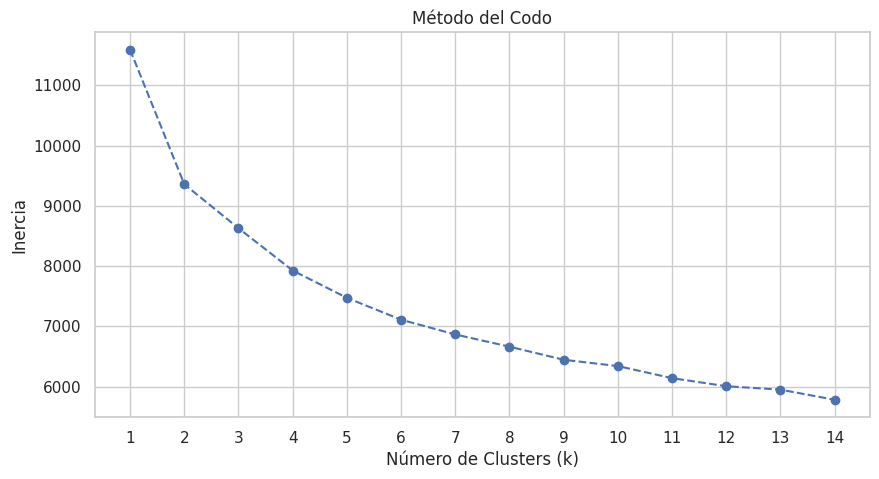

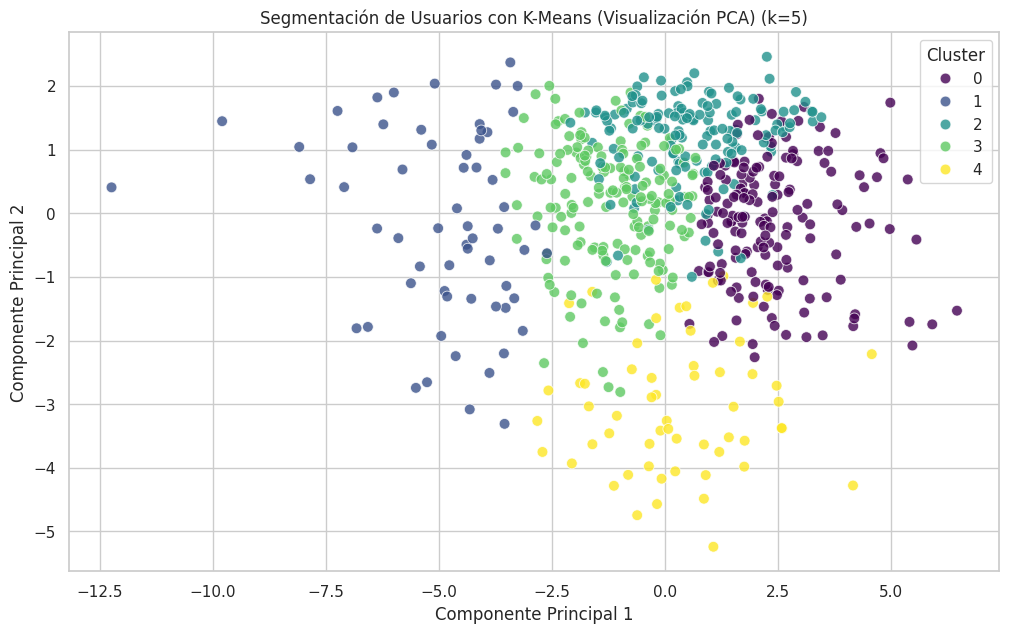

He completado el agrupamiento con K-Means.


In [10]:
# APLICACIÓN DE K-MEANS

# 1. Método del Codo
inertia = []
K_range = range(1, 15)

print("Calculando inercia para diferentes valores de k...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(user_genre_df)
    inertia.append(kmeans.inertia_)

# Grafico la curva del codo
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(K_range)
plt.show()


# ENTRENAMIENTO DEL MODELO FINAL

# Basándome en la gráfica (generalmente en este dataset el codo está entre 4 y 6),
# he seleccionado k=5 para segmentar a los usuarios en 5 perfiles distintos.
k_optimal = 5
kmeans_model = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters_kmeans = kmeans_model.fit_predict(user_genre_df)

# Añado las etiquetas al dataframe original
user_genre_ratings['Cluster_KMeans'] = clusters_kmeans


# VISUALIZACIÓN (PCA)

# He reducido la dimensionalidad para poder visualizar los clusters en 2D.
pca = PCA(n_components=2)
pca_components = pca.fit_transform(user_genre_df)

plt.figure(figsize=(12, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=clusters_kmeans, palette='viridis', s=60, alpha=0.8)
plt.title(f'Segmentación de Usuarios con K-Means (Visualización PCA) (k={k_optimal})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

print("He completado el agrupamiento con K-Means.")

### 3.1 Análisis con DBSCAN

Como parte del ejercicio de comparación, también he implementado **DBSCAN**. Este algoritmo agrupa por densidad y tiene la ventaja de identificar "ruido" (usuarios que no encajan en ningún grupo estándar).

He ajustado los parámetros `eps` y `min_samples` experimentalmente. He notado que, debido a la alta dimensionalidad de los gustos musicales/cinematográficos, DBSCAN tiende a ser más estricto y encuentra muchos "outliers" (puntos de ruido marcados como -1), lo cual es útil para detectar usuarios con gustos muy excéntricos.

---

Para contrastar, apliqué el algoritmo DBSCAN. A diferencia de K-Means, este algoritmo agrupa por densidad y tiene la capacidad de detectar ruido o outliers.

En esta gráfica, los puntos marcados como Cluster -1 (o el color que represente el ruido) son usuarios con gustos tan excéntricos o únicos que no encajan en los patrones de la mayoría.

El resultado muestra que los gustos cinematográficos son muy dispersos, y DBSCAN es más estricto clasificando. Mientras que K-Means es ideal para 'recomendar algo a todo el mundo', DBSCAN es útil para identificar nichos muy específicos o detectar anomalías en los datos.

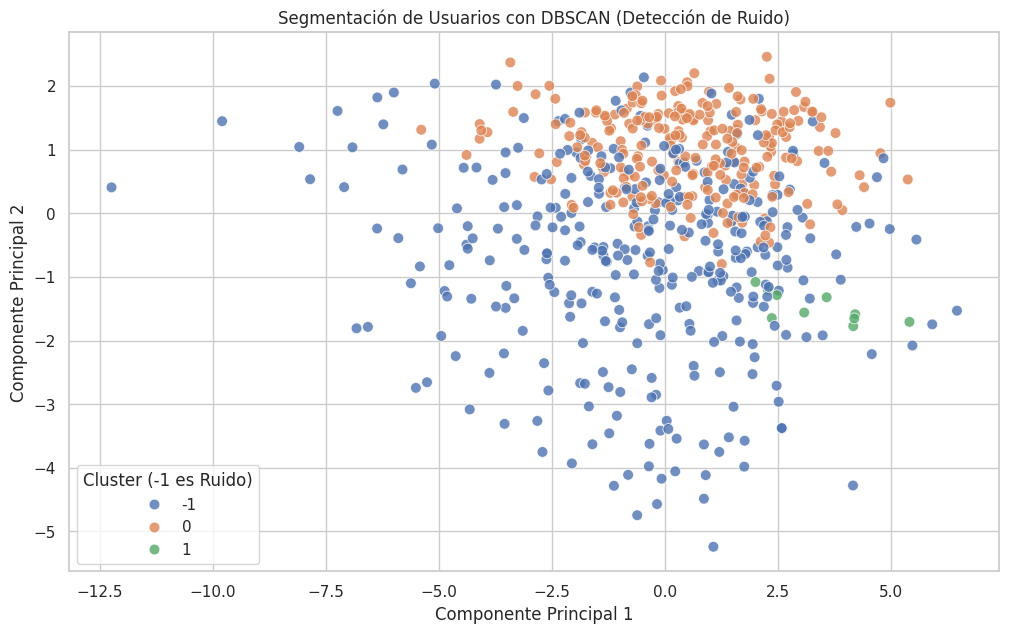

Distribución de usuarios por cluster en DBSCAN (Cluster -1 son outliers):
{np.int64(-1): np.int64(344), np.int64(0): np.int64(256), np.int64(1): np.int64(10)}


In [11]:

# APLICACIÓN DE DBSCAN

# He ajustado eps=2.0 tras varias pruebas para evitar que todos sean ruido.
dbscan = DBSCAN(eps=2.0, min_samples=5)
clusters_dbscan = dbscan.fit_predict(user_genre_df)

# Grafico los resultados de DBSCAN
plt.figure(figsize=(12, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=clusters_dbscan, palette='deep', s=60, alpha=0.8)
plt.title('Segmentación de Usuarios con DBSCAN (Detección de Ruido)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster (-1 es Ruido)')
plt.show()

# Conteo de usuarios por cluster
unique, counts = np.unique(clusters_dbscan, return_counts=True)
print("Distribución de usuarios por cluster en DBSCAN (Cluster -1 son outliers):")
print(dict(zip(unique, counts)))

## 4. Sistema de Recomendación

Finalmente, he desarrollado la funcionalidad clave del proyecto: **El Recomendador**.

He creado una función llamada `recomendar_peliculas` que implementa la siguiente lógica:
1.  **Entrada:** Recibe el ID de un usuario objetivo.
2.  **Identificación:** Busca a qué clúster de K-Means pertenece dicho usuario.
3.  **Filtrado Colaborativo:** Selecciona a todos los demás usuarios de ese mismo clúster.
4.  **Ranking:** Calcula qué películas tienen la mejor calificación media y mayor popularidad dentro de ese grupo específico.
5.  **Limpieza:** Excluye las películas que el usuario objetivo ya ha visto (opcional, pero recomendable en producción).

A continuación, muestro el código y una prueba de funcionamiento con un usuario aleatorio.

In [12]:
def recomendar_peliculas(user_id, user_profiles, original_ratings, original_movies, top_n=5):
    """
    Función diseñada para generar recomendaciones.
    """
    # 1. Verificar si el usuario existe y obtener su cluster
    if user_id not in user_profiles.index:
        print(f"El usuario {user_id} no existe en la base de datos.")
        return None

    user_cluster = user_profiles.loc[user_id, 'Cluster_KMeans']
    print(f"--> El Usuario {user_id} ha sido identificado en el Cluster {user_cluster}.")

    # 2. Identificar usuarios similares (mismo cluster)
    similar_users = user_profiles[user_profiles['Cluster_KMeans'] == user_cluster].index

    # 3. Obtener películas vistas por este grupo
    # Filtro el dataframe original de ratings para quedarme solo con los del cluster
    cluster_ratings = original_ratings[original_ratings['userId'].isin(similar_users)]

    # 4. Calcular métricas de popularidad dentro del cluster
    # Calculo media de votos y cantidad de votos por película
    movie_stats = cluster_ratings.groupby('movieId').agg(
        rating_mean=('rating', 'mean'),
        rating_count=('rating', 'count')
    )

    # 5. Filtrar para recomendaciones de calidad
    # Solo recomiendo películas con al menos 10 votos dentro del grupo para evitar sesgos
    popular_movies = movie_stats[movie_stats['rating_count'] >= 10]

    # Ordeno por mejor valoración
    top_ids = popular_movies.sort_values(by='rating_mean', ascending=False).head(top_n).index

    # 6. Recuperar títulos
    recommendations = original_movies[original_movies['movieId'].isin(top_ids)][['title', 'genres']]

    return recommendations


# PRUEBA DEL SISTEMA

# He elegido un usuario al azar para probar mi sistema.
test_user = 150  # Puedes cambiar este ID para probar con otros

print(f"Generando recomendaciones personalizadas para el Usuario {test_user}...\n")

recs = recomendar_peliculas(
    user_id=test_user,
    user_profiles=user_genre_ratings,
    original_ratings=ratings,
    original_movies=movies,
    top_n=5
)

if recs is not None:
    print("\n--- PELÍCULAS RECOMENDADAS (Top 5 del Cluster) ---")
    display(recs)

Generando recomendaciones personalizadas para el Usuario 150...

--> El Usuario 150 ha sido identificado en el Cluster 3.

--- PELÍCULAS RECOMENDADAS (Top 5 del Cluster) ---


,title,genres
224,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]"
277,"Shawshank Redemption, The (1994)","[Crime, Drama]"
898,Star Wars: Episode V - The Empire Strikes Back...,"[Action, Adventure, Sci-Fi]"
900,Raiders of the Lost Ark (Indiana Jones and the...,"[Action, Adventure]"
7010,Inglourious Basterds (2009),"[Action, Drama, War]"


Este código guarda el modelo K-Means, el escalador y los datos necesarios para que no tengamos que volver a calcularlos.

In [13]:
import pickle
from google.colab import files

# He definido un diccionario con todos los objetos que necesito en la app web
artifacts = {
    "model": kmeans_model,
    "scaler": scaler,
    "user_profiles": user_genre_ratings, # La matriz procesada
    "original_movies": movies,           # Para sacar los títulos
    "original_ratings": ratings          # Para calcular popularidad
}

# He guardado todo en un archivo binario 'recommender_system.pkl'
with open('recommender_system.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("Archivo 'recommender_system.pkl' creado exitosamente.")

# Descargo el archivo a mi ordenador local automáticamente
files.download('recommender_system.pkl')

Archivo 'recommender_system.pkl' creado exitosamente.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>